In [1]:
# FootballAdChanger - DINOv2 Feature Extraction & Segmentation
# Notebook per sperimentare con DINOv2 sui banner di calcio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from transformers import Dinov2Model, Dinov2Config
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pathlib import Path

# Setup dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'🔥 Dispositivo: {device}')
if torch.cuda.is_available():
    print(f'🎯 GPU: {torch.cuda.get_device_name(0)}')
    print(f'💾 VRAM disponibile: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')

🔥 Dispositivo: cuda
🎯 GPU: NVIDIA GeForce MX130
💾 VRAM disponibile: 1 GB


In [2]:
# Carica il dataset (riutilizziamo il lavoro fatto)
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'raw' / 'images'  # Le immagini sono in raw/images
ANNOTATIONS_FILE = DATA_DIR / 'annotations' / 'instances.json'  # Il file si chiama instances.json

# Verifica che i file esistano
print(f'📁 Controllo paths:')
print(f'   - DATA_DIR: {DATA_DIR.absolute()}')
print(f'   - IMAGES_DIR exists: {IMAGES_DIR.exists()}')
print(f'   - ANNOTATIONS_FILE exists: {ANNOTATIONS_FILE.exists()}')

if not ANNOTATIONS_FILE.exists():
    print('❌ File annotations non trovato!')
    print('   File trovati in annotations:')
    for item in (DATA_DIR / 'annotations').glob('*'):
        print(f'     {item}')
else:
    # Carica annotations
    with open(ANNOTATIONS_FILE, 'r') as f:
        coco_data = json.load(f)

    images = coco_data['images']
    annotations = coco_data['annotations']

    # Crea dizionario img_id -> annotations (come prima)
    img_annotations = {}
    for ann in annotations:
        img_id = ann['image_id']
        if img_id not in img_annotations:
            img_annotations[img_id] = []
        img_annotations[img_id].append(ann)

    print(f'📊 Dataset caricato:')
    print(f'   - {len(images)} immagini')
    print(f'   - {len(annotations)} annotazioni banner')
    print(f'   - {len(img_annotations)} immagini con banner')

📁 Controllo paths:
   - DATA_DIR: /home/gabriele/FootballAdChanger/notebooks/../data
   - IMAGES_DIR exists: True
   - ANNOTATIONS_FILE exists: True
📊 Dataset caricato:
   - 45 immagini
   - 121 annotazioni banner
   - 20 immagini con banner


In [3]:
# 🤖 Carica DINOv2 pre-trainato
print('🔄 Caricamento DINOv2...')

# Modello DINOv2 (ViT-Small per iniziare)
model_name = "facebook/dinov2-small"
dinov2_model = Dinov2Model.from_pretrained(model_name)
dinov2_model = dinov2_model.to(device)
dinov2_model.eval()

# Configurazione modello
config = dinov2_model.config
print(f'✅ DINOv2 caricato: {model_name}')
print(f'   - Patch size: {config.patch_size}')
print(f'   - Hidden size: {config.hidden_size}')
print(f'   - Image size: {config.image_size}')

# Transform per preprocessing
transform = T.Compose([
    T.Resize((config.image_size, config.image_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

🔄 Caricamento DINOv2...
✅ DINOv2 caricato: facebook/dinov2-small
   - Patch size: 14
   - Hidden size: 384
   - Image size: 518


In [4]:
# 🎯 Testa estrazione features su un'immagine campione
def extract_dinov2_features(image_path, model, transform, device):
    """Estrae features DINOv2 da un'immagine"""
    
    # Carica e preprocessa immagine
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Forward pass attraverso DINOv2
        outputs = model(input_tensor)
        
        # Prendi le features dell'ultimo layer
        features = outputs.last_hidden_state  # [1, num_patches+1, hidden_size]
        
        # Rimuovi CLS token (primo token)
        patch_features = features[:, 1:, :]  # [1, num_patches, hidden_size]
        
    return patch_features, image

# Test su prima immagine con banner
test_img_id = list(img_annotations.keys())[0]
test_img_info = next(img for img in images if img['id'] == test_img_id)
test_img_path = IMAGES_DIR / test_img_info['file_name']

print(f'🧪 Test su: {test_img_info["file_name"]}')
print(f'   - Dimensioni: {test_img_info["width"]}x{test_img_info["height"]}')
print(f'   - Banner: {len(img_annotations[test_img_id])}')

# Estrai features
features, original_image = extract_dinov2_features(test_img_path, dinov2_model, transform, device)

print(f'✅ Features estratte:')
print(f'   - Shape: {features.shape}')
print(f'   - Patches: {features.shape[1]}')
print(f'   - Feature dim: {features.shape[2]}')

🧪 Test su: frame_00000.jpg
   - Dimensioni: 640x360
   - Banner: 2
✅ Features estratte:
   - Shape: torch.Size([1, 1369, 384])
   - Patches: 1369
   - Feature dim: 384


/tmp/ipykernel_5097/663841618.py:35: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_5097/663841618.py:35: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


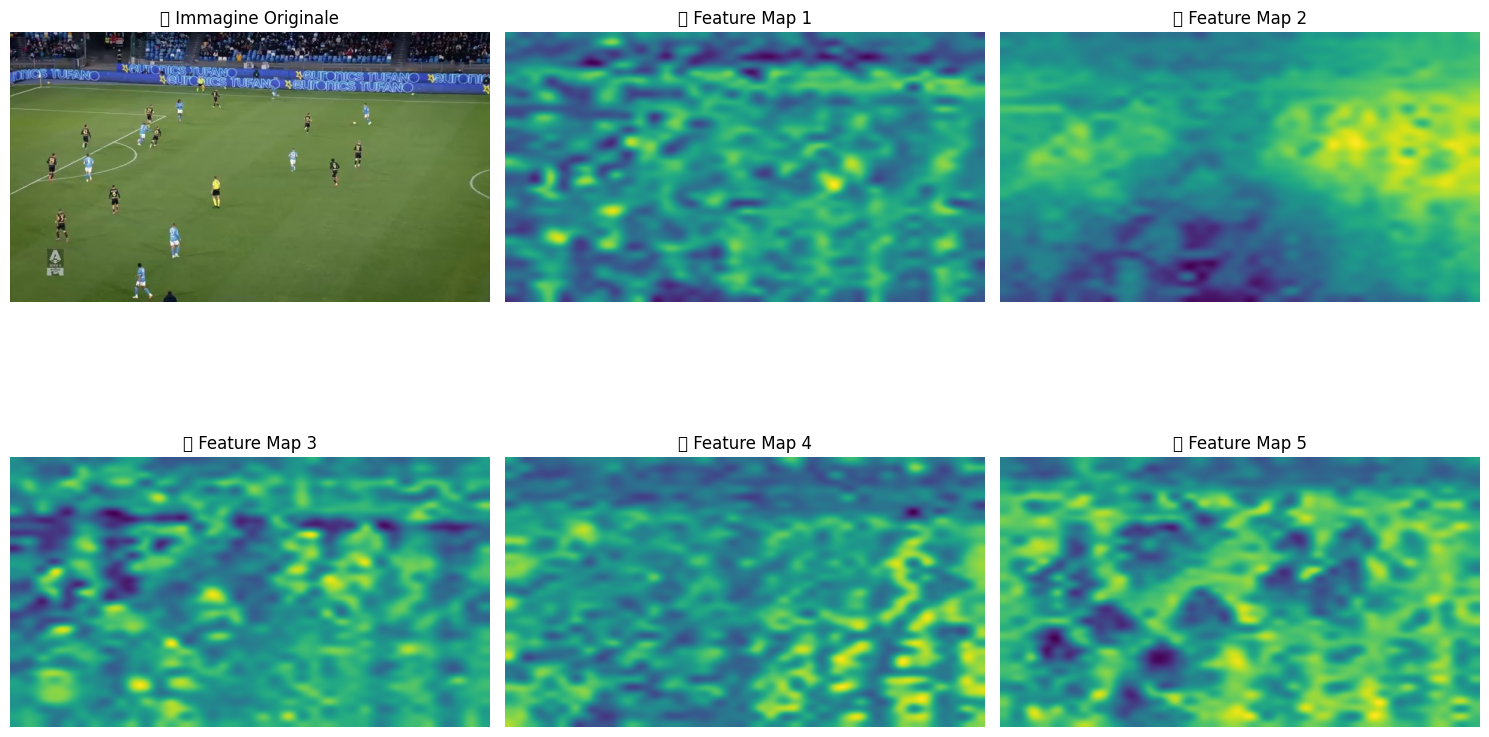

📊 Feature grid shape: (37, 37, 384)


In [5]:
# 🎨 Visualizza le features DINOv2 come attention maps
def visualize_dinov2_features(features, original_image, patch_size=14, num_maps=6):
    """Visualizza le features di DINOv2 come mappe di attenzione"""
    
    # Calcola dimensioni griglia patches
    h_patches = w_patches = int(np.sqrt(features.shape[1]))
    
    # Reshape features in griglia spaziale
    features_2d = features[0].cpu().numpy()  # [num_patches, hidden_size]
    features_grid = features_2d.reshape(h_patches, w_patches, -1)
    
    # Visualizza diverse componenti delle features
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Immagine originale
    axes[0].imshow(original_image)
    axes[0].set_title('🖼️ Immagine Originale')
    axes[0].axis('off')
    
    # Prime 5 componenti delle features
    for i in range(1, num_maps):
        feature_map = features_grid[:, :, i-1]
        
        # Normalizza tra 0-1
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        
        # Resize alla dimensione originale
        feature_map_resized = cv2.resize(feature_map, original_image.size, interpolation=cv2.INTER_CUBIC)
        
        axes[i].imshow(feature_map_resized, cmap='viridis')
        axes[i].set_title(f'🧠 Feature Map {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return features_grid

# Visualizza features
features_grid = visualize_dinov2_features(features, original_image)
print(f'📊 Feature grid shape: {features_grid.shape}')

In [7]:
# 🏗️ Definiamo una semplice Segmentation Head per DINOv2
class DINOv2SegmentationHead(nn.Module):
    """Testa di segmentazione per DINOv2"""
    
    def __init__(self, dinov2_model, num_classes=2, hidden_size=384):  # 2 classi: background, banner
        super().__init__()
        self.dinov2 = dinov2_model
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        # Decoder semplice per segmentazione
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_size, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, 1)
        )
        
        # Freeze DINOv2 backbone (per few-shot learning)
        for param in self.dinov2.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Estrai features da DINOv2
        with torch.no_grad():
            outputs = self.dinov2(x)
            features = outputs.last_hidden_state[:, 1:, :]  # Remove CLS token
        
        # Calcola dimensioni griglia
        h_patches = w_patches = int(np.sqrt(features.shape[1]))
        
        # Reshape in formato spaziale [B, hidden_size, H, W]
        features_spatial = features.reshape(batch_size, h_patches, w_patches, self.hidden_size)
        features_spatial = features_spatial.permute(0, 3, 1, 2)  # [B, C, H, W]
        
        # Passa attraverso decoder
        logits = self.decoder(features_spatial)
        
        # Upsampling alla risoluzione originale (224x224)
        logits = F.interpolate(logits, size=(224, 224), mode='bilinear', align_corners=False)
        
        return logits

# Crea il modello di segmentazione
segmentation_model = DINOv2SegmentationHead(dinov2_model, num_classes=2)
segmentation_model = segmentation_model.to(device)

print(f'🏗️ Modello di segmentazione creato:')
print(f'   - Backbone: DINOv2 (frozen)')
print(f'   - Decoder: Conv layers (trainable)')
print(f'   - Output: 2 classi (background, banner)')

# Conta parametri trainable
trainable_params = sum(p.numel() for p in segmentation_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in segmentation_model.parameters())
print(f'   - Parametri trainable: {trainable_params:,}')
print(f'   - Parametri totali: {total_params:,}')

🏗️ Modello di segmentazione creato:
   - Backbone: DINOv2 (frozen)
   - Decoder: Conv layers (trainable)
   - Output: 2 classi (background, banner)
   - Parametri trainable: 1,180,290
   - Parametri totali: 23,236,866


In [8]:
# 🧪 Test forward pass del modello di segmentazione
print('🧪 Test forward pass...')

# Prepara immagine di test
test_tensor = transform(original_image).unsqueeze(0).to(device)
print(f'📥 Input shape: {test_tensor.shape}')

# Forward pass
with torch.no_grad():
    segmentation_logits = segmentation_model(test_tensor)

print(f'📤 Output shape: {segmentation_logits.shape}')
print(f'✅ Forward pass completato!')

# Converti logits in probabilità e maschera
segmentation_probs = torch.softmax(segmentation_logits, dim=1)
segmentation_mask = torch.argmax(segmentation_probs, dim=1)

print(f'🎯 Probabilità shape: {segmentation_probs.shape}')
print(f'🎭 Maschera shape: {segmentation_mask.shape}')

🧪 Test forward pass...
📥 Input shape: torch.Size([1, 3, 518, 518])
📤 Output shape: torch.Size([1, 2, 224, 224])
✅ Forward pass completato!
🎯 Probabilità shape: torch.Size([1, 2, 224, 224])
🎭 Maschera shape: torch.Size([1, 224, 224])


/tmp/ipykernel_548/1125421768.py:34: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/1125421768.py:34: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/1125421768.py:34: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/1125421768.py:34: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/gabriele

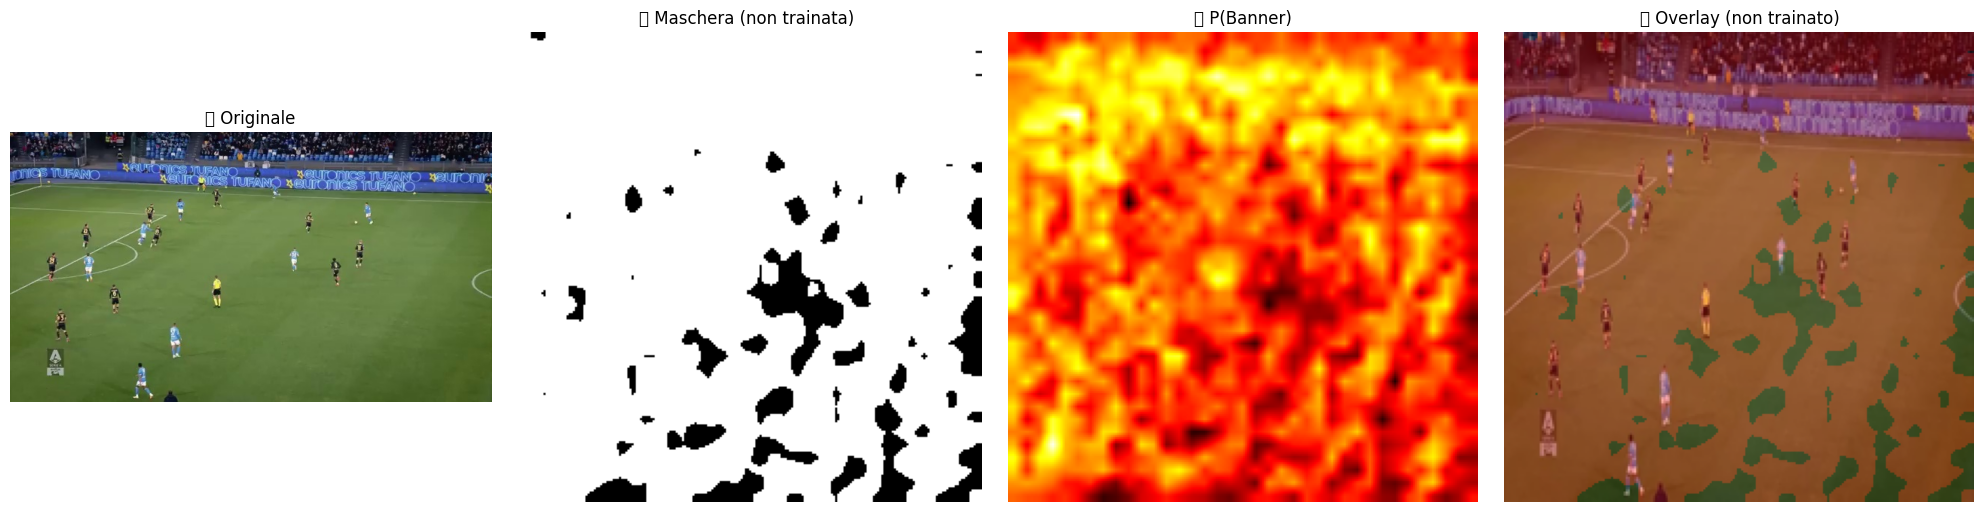

⚠️  NOTA: Il modello NON è ancora trainato!
   Le predizioni sono casuali. Prossimo step: training!


In [9]:
# 🎨 Visualizza risultati preliminari
def visualize_segmentation_results(original_image, mask, probs):
    """Visualizza risultati di segmentazione"""
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Immagine originale
    axes[0].imshow(original_image)
    axes[0].set_title('🖼️ Originale')
    axes[0].axis('off')
    
    # Maschera predetta (non trainata ancora!)
    mask_np = mask[0].cpu().numpy()
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('🎭 Maschera (non trainata)')
    axes[1].axis('off')
    
    # Probabilità banner
    banner_prob = probs[0, 1].cpu().numpy()  # Classe banner
    axes[2].imshow(banner_prob, cmap='hot')
    axes[2].set_title('🔥 P(Banner)')
    axes[2].axis('off')
    
    # Overlay
    overlay = np.array(original_image.resize((224, 224)))
    mask_colored = np.zeros_like(overlay)
    mask_colored[mask_np == 1] = [255, 0, 0]  # Rosso per banner
    
    blended = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)
    axes[3].imshow(blended)
    axes[3].set_title('🎨 Overlay (non trainato)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizza (ricorda: il modello NON è ancora trainato!)
visualize_segmentation_results(original_image, segmentation_mask, segmentation_probs)

print('⚠️  NOTA: Il modello NON è ancora trainato!')
print('   Le predizioni sono casuali. Prossimo step: training!')

In [10]:
# 📊 Statistiche del modello e prossimi passi
print('📊 RIEPILOGO SPERIMENTAZIONE DINOv2:')
print('=' * 50)
print(f'✅ DINOv2 caricato e funzionante')
print(f'✅ Features estratte: {features.shape}')
print(f'✅ Segmentation head implementata')
print(f'✅ Forward pass completato')
print(f'✅ Visualizzazioni create')
print()
print('🎯 PROSSIMI PASSI:')
print('1. 📝 Preparare dati di training (formato masks)')
print('2. 🏋️ Training loop con le tue 20 immagini etichettate')
print('3. 🔧 Data augmentation per few-shot learning')
print('4. 🎨 Inpainting pipeline per sostituzione banner')
print()
print('💡 Il setup DINOv2 funziona perfettamente!')
print('   Pronto per il training con il tuo dataset COCO!')

📊 RIEPILOGO SPERIMENTAZIONE DINOv2:
✅ DINOv2 caricato e funzionante
✅ Features estratte: torch.Size([1, 1369, 384])
✅ Segmentation head implementata
✅ Forward pass completato
✅ Visualizzazioni create

🎯 PROSSIMI PASSI:
1. 📝 Preparare dati di training (formato masks)
2. 🏋️ Training loop con le tue 20 immagini etichettate
3. 🔧 Data augmentation per few-shot learning
4. 🎨 Inpainting pipeline per sostituzione banner

💡 Il setup DINOv2 funziona perfettamente!
   Pronto per il training con il tuo dataset COCO!


In [12]:
# 🎯 PREPARAZIONE DATI PER TRAINING
# Convertiamo le annotazioni COCO in maschere per il training

import cv2
from pycocotools import mask as coco_mask
from sklearn.model_selection import train_test_split

def coco_polygon_to_mask(polygon, image_width, image_height):
    """Converte poligono COCO in maschera binaria"""
    
    # COCO polygon format: [x1,y1,x2,y2,...] appiattito
    # Reshape in coordinate (x,y)
    polygon_points = np.array(polygon).reshape(-1, 2).astype(np.int32)
    
    # Crea maschera vuota
    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    
    # Riempi poligono
    cv2.fillPoly(mask, [polygon_points], 1)
    
    return mask

def prepare_training_data(images, annotations, img_annotations, images_dir):
    """Prepara dati per training: immagini + maschere"""
    
    training_data = []
    
    for img_id, anns in img_annotations.items():
        # Info immagine
        img_info = next(img for img in images if img['id'] == img_id)
        img_path = images_dir / img_info['file_name']
        
        if not img_path.exists():
            continue
            
        # Dimensioni immagine
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Crea maschera combinata per tutti i banner in questa immagine
        combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        for ann in anns:
            if 'segmentation' in ann and ann['segmentation']:
                # Prendi prima segmentazione (se ce ne sono multiple)
                polygon = ann['segmentation'][0]
                
                # Converti in maschera
                mask = coco_polygon_to_mask(polygon, img_width, img_height)
                
                # Aggiungi alla maschera combinata
                combined_mask = np.maximum(combined_mask, mask)
        
        training_data.append({
            'image_path': img_path,
            'mask': combined_mask,
            'image_info': img_info,
            'num_banners': len(anns)
        })
    
    return training_data

# Prepara dati di training
print('🔄 Preparazione dati di training...')
training_data = prepare_training_data(images, annotations, img_annotations, IMAGES_DIR)

print(f'✅ Dati preparati:')
print(f'   - {len(training_data)} immagini con banner')
print(f'   - Risoluzione: 640x360')
print(f'   - Formato maschere: binarie (0=background, 1=banner)')

🔄 Preparazione dati di training...
✅ Dati preparati:
   - 20 immagini con banner
   - Risoluzione: 640x360
   - Formato maschere: binarie (0=background, 1=banner)



📋 Esempio 1/20:


/tmp/ipykernel_548/915606412.py:47: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/915606412.py:47: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/915606412.py:47: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/915606412.py:47: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


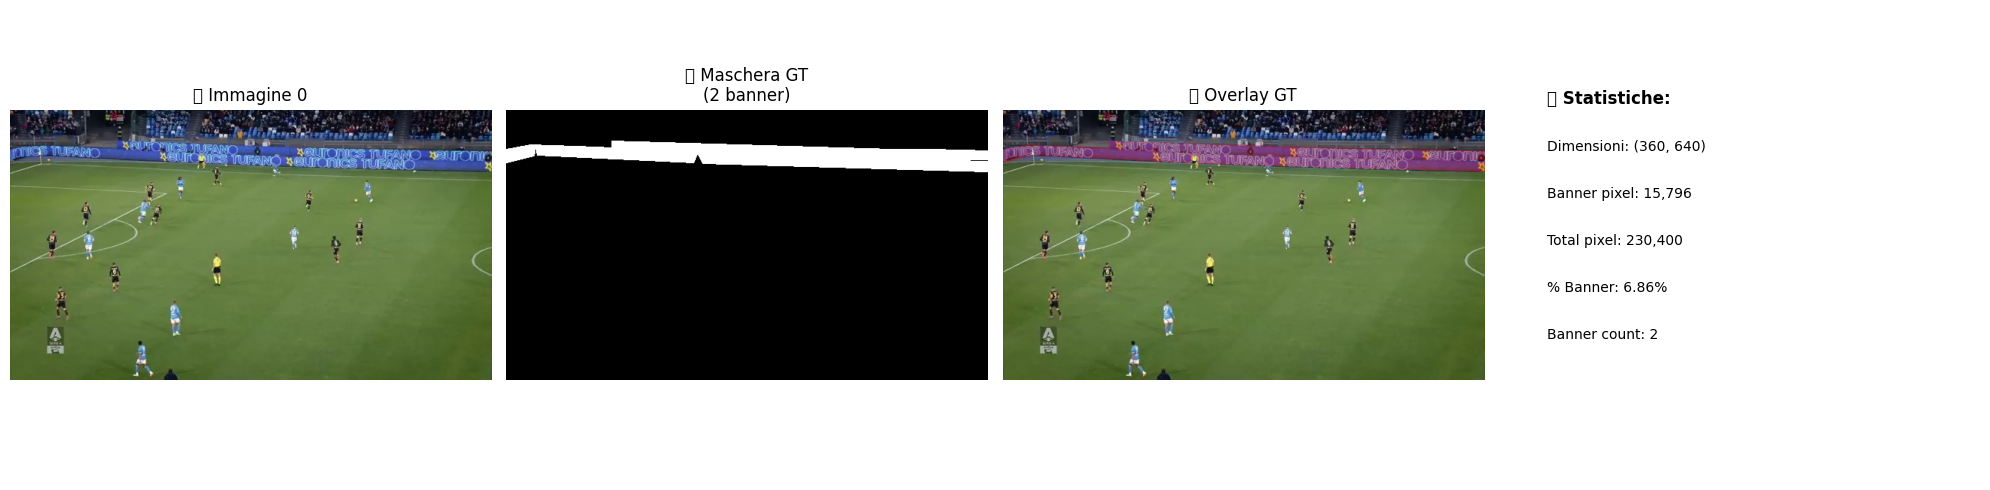


📋 Esempio 2/20:


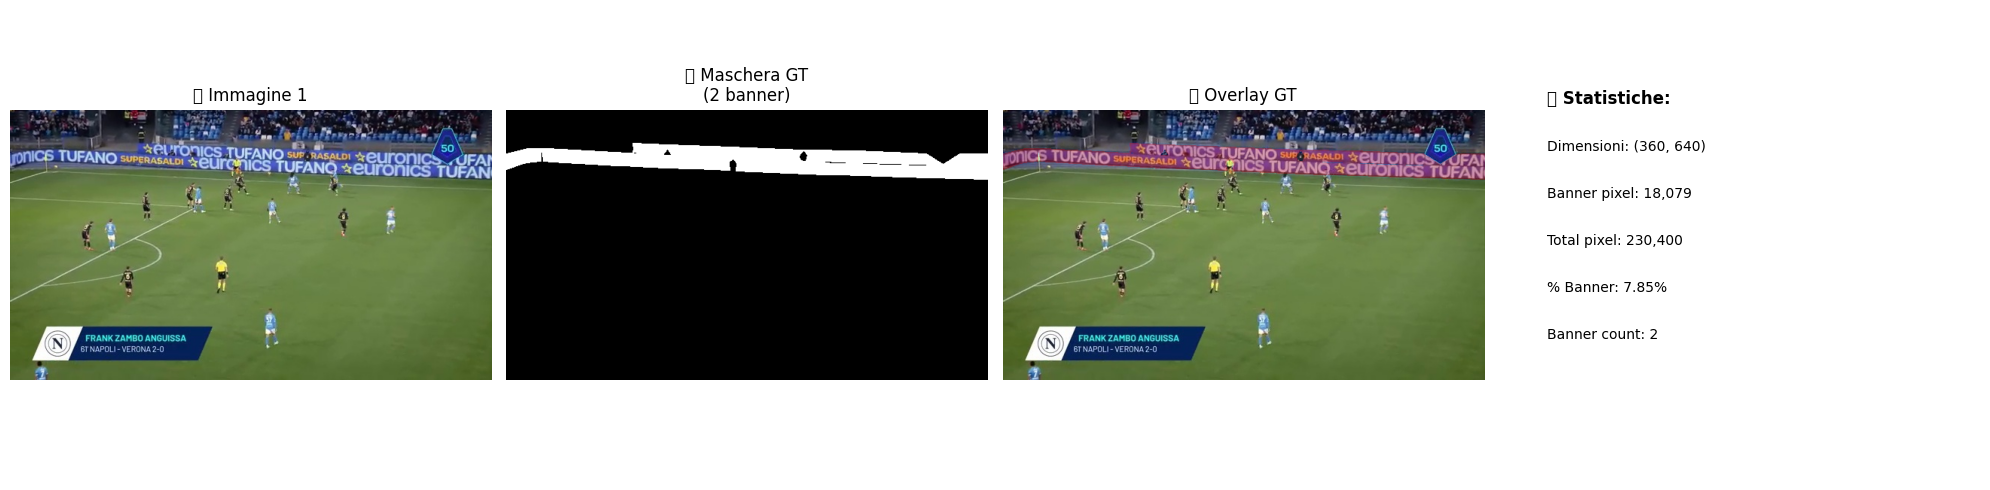


📋 Esempio 3/20:


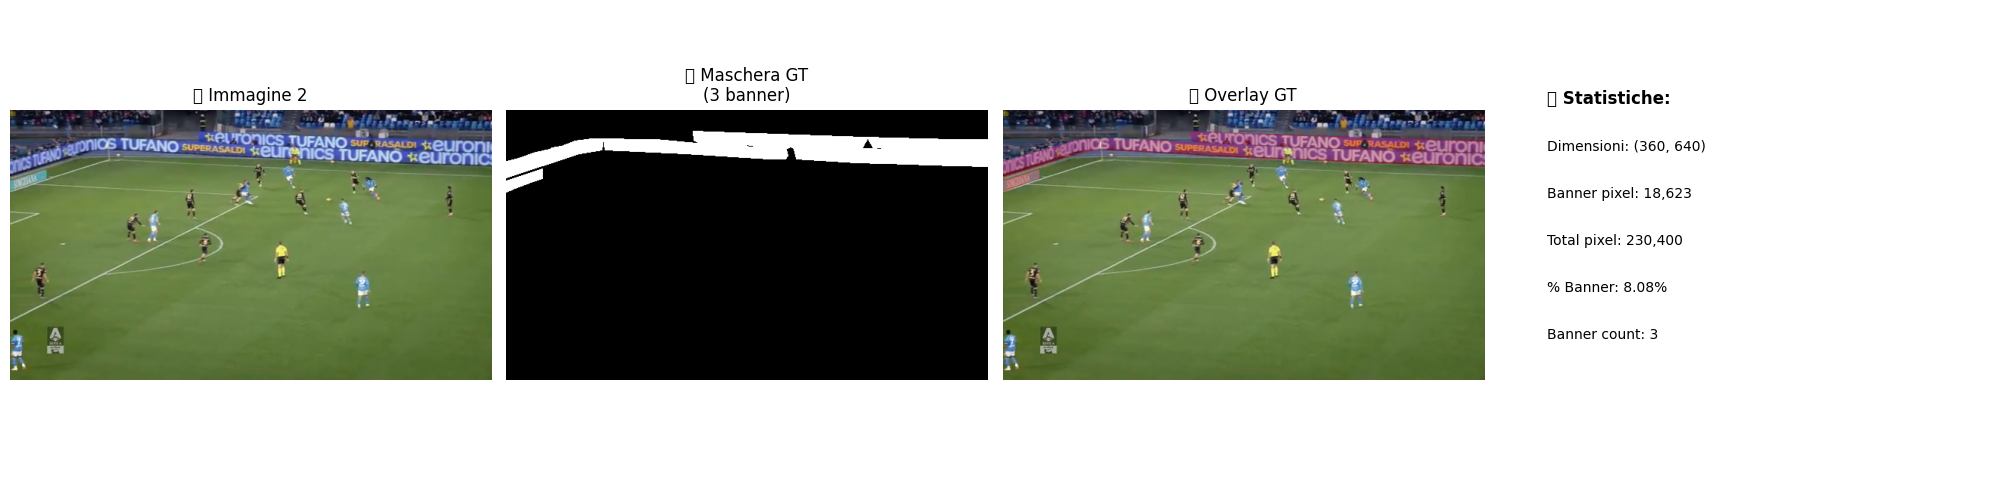

In [13]:
# 🎨 Visualizza alcuni esempi di maschere generate
def visualize_training_sample(sample_idx=0):
    """Visualizza esempio di training data"""
    
    sample = training_data[sample_idx]
    
    # Carica immagine
    image = cv2.imread(str(sample['image_path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Maschera
    mask = sample['mask']
    
    # Overlay
    overlay = image.copy()
    overlay[mask == 1] = [255, 0, 0]  # Rosso per banner
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
    # Visualizza
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(image)
    axes[0].set_title(f'🖼️ Immagine {sample_idx}')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f'🎭 Maschera GT\n({sample["num_banners"]} banner)')
    axes[1].axis('off')
    
    axes[2].imshow(blended)
    axes[2].set_title('🎨 Overlay GT')
    axes[2].axis('off')
    
    # Statistiche maschera
    banner_pixels = np.sum(mask == 1)
    total_pixels = mask.shape[0] * mask.shape[1]
    banner_percentage = (banner_pixels / total_pixels) * 100
    
    axes[3].text(0.1, 0.8, f'📊 Statistiche:', fontsize=12, weight='bold')
    axes[3].text(0.1, 0.7, f'Dimensioni: {image.shape[:2]}', fontsize=10)
    axes[3].text(0.1, 0.6, f'Banner pixel: {banner_pixels:,}', fontsize=10)
    axes[3].text(0.1, 0.5, f'Total pixel: {total_pixels:,}', fontsize=10)
    axes[3].text(0.1, 0.4, f'% Banner: {banner_percentage:.2f}%', fontsize=10)
    axes[3].text(0.1, 0.3, f'Banner count: {sample["num_banners"]}', fontsize=10)
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizza primi 3 esempi
for i in range(min(3, len(training_data))):
    print(f'\n📋 Esempio {i+1}/{len(training_data)}:')
    visualize_training_sample(i)

In [14]:
# 🏋️ DATASET CLASSE per PyTorch Training
from torch.utils.data import Dataset, DataLoader

class FootballBannerDataset(Dataset):
    """Dataset per segmentazione banner di calcio"""
    
    def __init__(self, training_data, transform=None, target_size=224):
        self.training_data = training_data
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.training_data)
    
    def __getitem__(self, idx):
        sample = self.training_data[idx]
        
        # Carica immagine
        image = Image.open(sample['image_path']).convert('RGB')
        mask = sample['mask']
        
        # Resize immagine e maschera a target_size
        image_resized = image.resize((self.target_size, self.target_size), Image.BICUBIC)
        mask_resized = cv2.resize(mask, (self.target_size, self.target_size), interpolation=cv2.INTER_NEAREST)
        
        # Applica transform all'immagine
        if self.transform:
            image_tensor = self.transform(image_resized)
        else:
            image_tensor = T.ToTensor()(image_resized)
        
        # Converti maschera in tensor
        mask_tensor = torch.from_numpy(mask_resized).long()
        
        return image_tensor, mask_tensor

# Crea dataset
dataset = FootballBannerDataset(training_data, transform=transform)

# Split train/validation (80/20)
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)

train_dataset = FootballBannerDataset(train_data, transform=transform)
val_dataset = FootballBannerDataset(val_data, transform=transform)

print(f'📊 Dataset creato:')
print(f'   - Training samples: {len(train_dataset)}')
print(f'   - Validation samples: {len(val_dataset)}')
print(f'   - Input size: 224x224')
print(f'   - Classes: 2 (background=0, banner=1)')

# Test del dataset
sample_image, sample_mask = dataset[0]
print(f'\n🧪 Test sample:')
print(f'   - Image shape: {sample_image.shape}')
print(f'   - Mask shape: {sample_mask.shape}')
print(f'   - Unique mask values: {torch.unique(sample_mask)}')

📊 Dataset creato:
   - Training samples: 16
   - Validation samples: 4
   - Input size: 224x224
   - Classes: 2 (background=0, banner=1)

🧪 Test sample:
   - Image shape: torch.Size([3, 518, 518])
   - Mask shape: torch.Size([224, 224])
   - Unique mask values: tensor([0, 1])


In [15]:
# 🎯 TRAINING SETUP
from torch.utils.data import DataLoader
import torch.optim as optim

# Hyperparameters
BATCH_SIZE = 4  # Small batch per few-shot learning
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
DEVICE = device

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Loss function per segmentazione
criterion = nn.CrossEntropyLoss()

# Optimizer (solo parametri trainable del decoder)
optimizer = optim.Adam(segmentation_model.parameters(), lr=LEARNING_RATE)

print(f'🏋️ Training setup:')
print(f'   - Batch size: {BATCH_SIZE}')
print(f'   - Learning rate: {LEARNING_RATE}')
print(f'   - Epochs: {NUM_EPOCHS}')
print(f'   - Training batches: {len(train_loader)}')
print(f'   - Validation batches: {len(val_loader)}')
print(f'   - Device: {DEVICE}')

# Funzione per calcolare accuratezza
def calculate_accuracy(outputs, targets):
    """Calcola accuratezza pixel-wise"""
    predictions = torch.argmax(outputs, dim=1)
    correct = (predictions == targets).float()
    accuracy = correct.mean()
    return accuracy.item()

# Funzione per calcolare IoU per classe banner
def calculate_banner_iou(outputs, targets):
    """Calcola IoU specificatamente per i banner (classe 1)"""
    predictions = torch.argmax(outputs, dim=1)
    
    # Maschere per classe banner
    pred_banner = (predictions == 1)
    target_banner = (targets == 1)
    
    # IoU calculation
    intersection = (pred_banner & target_banner).float().sum()
    union = (pred_banner | target_banner).float().sum()
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    iou = intersection / union
    return iou.item()

print(f'✅ Metriche configurate: Accuracy + Banner IoU')

🏋️ Training setup:
   - Batch size: 4
   - Learning rate: 0.0001
   - Epochs: 50
   - Training batches: 4
   - Validation batches: 1
   - Device: cuda
✅ Metriche configurate: Accuracy + Banner IoU


In [16]:
# 🚀 TRAINING LOOP
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Training per una epoch"""
    model.train()
    
    total_loss = 0
    total_accuracy = 0
    total_iou = 0
    num_batches = 0
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        
        # Loss
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metriche
        accuracy = calculate_accuracy(outputs, masks)
        banner_iou = calculate_banner_iou(outputs, masks)
        
        total_loss += loss.item()
        total_accuracy += accuracy
        total_iou += banner_iou
        num_batches += 1
        
        if batch_idx % 2 == 0:  # Print ogni 2 batch
            print(f'   Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}, Acc={accuracy:.3f}, IoU={banner_iou:.3f}')
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_iou = total_iou / num_batches
    
    return avg_loss, avg_accuracy, avg_iou

def validate_epoch(model, val_loader, criterion, device):
    """Validation per una epoch"""
    model.eval()
    
    total_loss = 0
    total_accuracy = 0
    total_iou = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            accuracy = calculate_accuracy(outputs, masks)
            banner_iou = calculate_banner_iou(outputs, masks)
            
            total_loss += loss.item()
            total_accuracy += accuracy
            total_iou += banner_iou
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_iou = total_iou / num_batches
    
    return avg_loss, avg_accuracy, avg_iou

print('🔥 PRONTO PER IL TRAINING!')
print('💡 Esegui la prossima cella per iniziare il training vero e proprio!')

🔥 PRONTO PER IL TRAINING!
💡 Esegui la prossima cella per iniziare il training vero e proprio!


In [17]:
# 🔥 AVVIO TRAINING DINOV2 + SEGMENTATION HEAD
print('🚀 INIZIAMO IL TRAINING!')
print('=' * 60)

# Sposta modello in modalità training
segmentation_model.train()

# Tracciamento metriche
train_losses = []
train_accuracies = []
train_ious = []
val_losses = []
val_accuracies = []
val_ious = []

best_val_iou = 0.0
best_model_state = None

# TRAINING LOOP PRINCIPALE
for epoch in range(NUM_EPOCHS):
    print(f'\n📅 EPOCH {epoch+1}/{NUM_EPOCHS}')
    print('-' * 40)
    
    # Training
    print('🏋️ Training...')
    train_loss, train_acc, train_iou = train_epoch(
        segmentation_model, train_loader, criterion, optimizer, DEVICE
    )
    
    # Validation
    print('🔍 Validation...')
    val_loss, val_acc, val_iou = validate_epoch(
        segmentation_model, val_loader, criterion, DEVICE
    )
    
    # Salva metriche
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_ious.append(train_iou)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_ious.append(val_iou)
    
    # Salva miglior modello
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_state = segmentation_model.state_dict().copy()
        print(f'🎯 Nuovo miglior modello! Val IoU: {val_iou:.4f}')
    
    # Stampa riassunto epoch
    print(f'📊 EPOCH {epoch+1} SUMMARY:')
    print(f'   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, IoU: {train_iou:.3f}')
    print(f'   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, IoU: {val_iou:.3f}')
    
    # Early stopping semplice
    if epoch > 10 and val_iou > 0.8:  # Se raggiungiamo 80% IoU sui banner
        print(f'🎉 EARLY STOPPING! Ottimo IoU raggiunto: {val_iou:.3f}')
        break

# Carica miglior modello
if best_model_state is not None:
    segmentation_model.load_state_dict(best_model_state)
    print(f'\n✅ Caricato miglior modello con Val IoU: {best_val_iou:.4f}')

print('\n🏁 TRAINING COMPLETATO!')

🚀 INIZIAMO IL TRAINING!

📅 EPOCH 1/50
----------------------------------------
🏋️ Training...
   Batch 0/4: Loss=0.8670, Acc=0.120, IoU=0.070
   Batch 2/4: Loss=0.2739, Acc=0.918, IoU=0.000
🔍 Validation...
📊 EPOCH 1 SUMMARY:
   Train - Loss: 0.4433, Acc: 0.726, IoU: 0.018
   Val   - Loss: 0.2008, Acc: 0.938, IoU: 0.000

📅 EPOCH 2/50
----------------------------------------
🏋️ Training...
   Batch 0/4: Loss=0.1936, Acc=0.941, IoU=0.000
   Batch 2/4: Loss=0.1918, Acc=0.935, IoU=0.000
🔍 Validation...
📊 EPOCH 2 SUMMARY:
   Train - Loss: 0.2086, Acc: 0.929, IoU: 0.000
   Val   - Loss: 0.1521, Acc: 0.938, IoU: 0.000

📅 EPOCH 3/50
----------------------------------------
🏋️ Training...
   Batch 0/4: Loss=0.1776, Acc=0.927, IoU=0.000
   Batch 2/4: Loss=0.1148, Acc=0.933, IoU=0.000
🔍 Validation...
🎯 Nuovo miglior modello! Val IoU: 0.0055
📊 EPOCH 3 SUMMARY:
   Train - Loss: 0.1398, Acc: 0.929, IoU: 0.000
   Val   - Loss: 0.1013, Acc: 0.938, IoU: 0.006

📅 EPOCH 4/50
------------------------------

/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_548/977199979.py:54

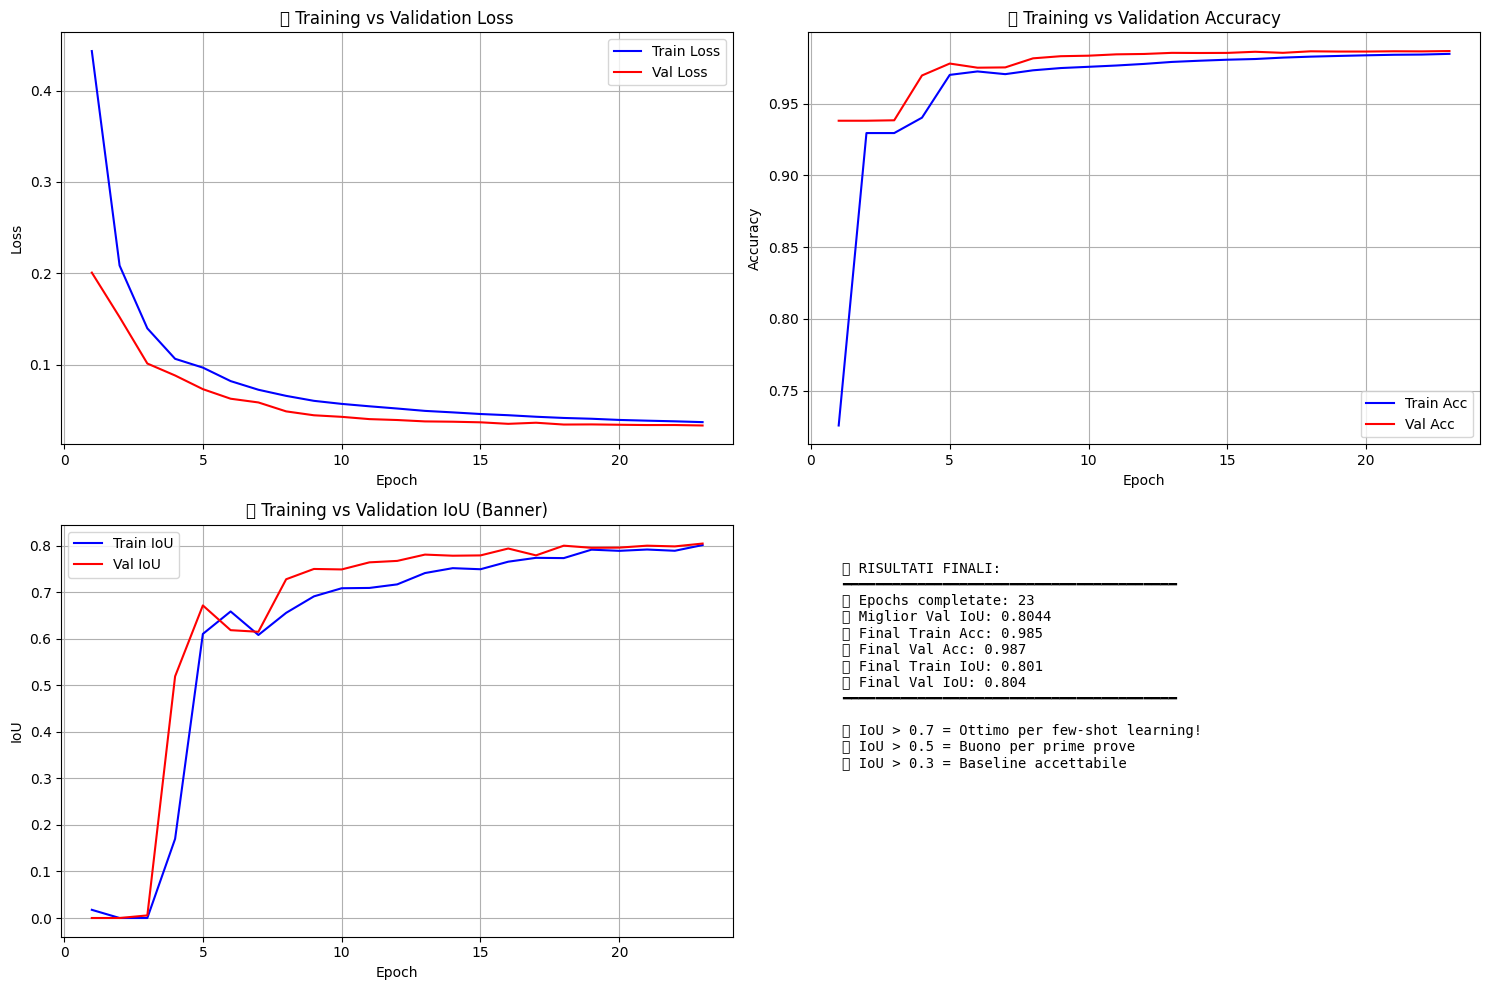

📈 Grafici delle metriche generati!


In [18]:
# 📈 VISUALIZZA METRICHE DI TRAINING
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(train_losses) + 1)

# Loss
axes[0, 0].plot(epochs_range, train_losses, 'b-', label='Train Loss')
axes[0, 0].plot(epochs_range, val_losses, 'r-', label='Val Loss')
axes[0, 0].set_title('📉 Training vs Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(epochs_range, train_accuracies, 'b-', label='Train Acc')
axes[0, 1].plot(epochs_range, val_accuracies, 'r-', label='Val Acc')
axes[0, 1].set_title('📊 Training vs Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# IoU
axes[1, 0].plot(epochs_range, train_ious, 'b-', label='Train IoU')
axes[1, 0].plot(epochs_range, val_ious, 'r-', label='Val IoU')
axes[1, 0].set_title('🎯 Training vs Validation IoU (Banner)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Metriche finali
final_stats = f"""
🏆 RISULTATI FINALI:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📅 Epochs completate: {len(train_losses)}
🎯 Miglior Val IoU: {best_val_iou:.4f}
📊 Final Train Acc: {train_accuracies[-1]:.3f}
📊 Final Val Acc: {val_accuracies[-1]:.3f}
🎭 Final Train IoU: {train_ious[-1]:.3f}
🎭 Final Val IoU: {val_ious[-1]:.3f}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 IoU > 0.7 = Ottimo per few-shot learning!
💡 IoU > 0.5 = Buono per prime prove
💡 IoU > 0.3 = Baseline accettabile
"""

axes[1, 1].text(0.05, 0.95, final_stats, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print('📈 Grafici delle metriche generati!')

🧪 TESTIAMO IL MODELLO TRAINATO!
🔍 TEST SU VALIDATION SAMPLES:

🧪 Sample 1:


/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_548/2877954415.py:71: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gabriele/FootballAdChanger/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  f

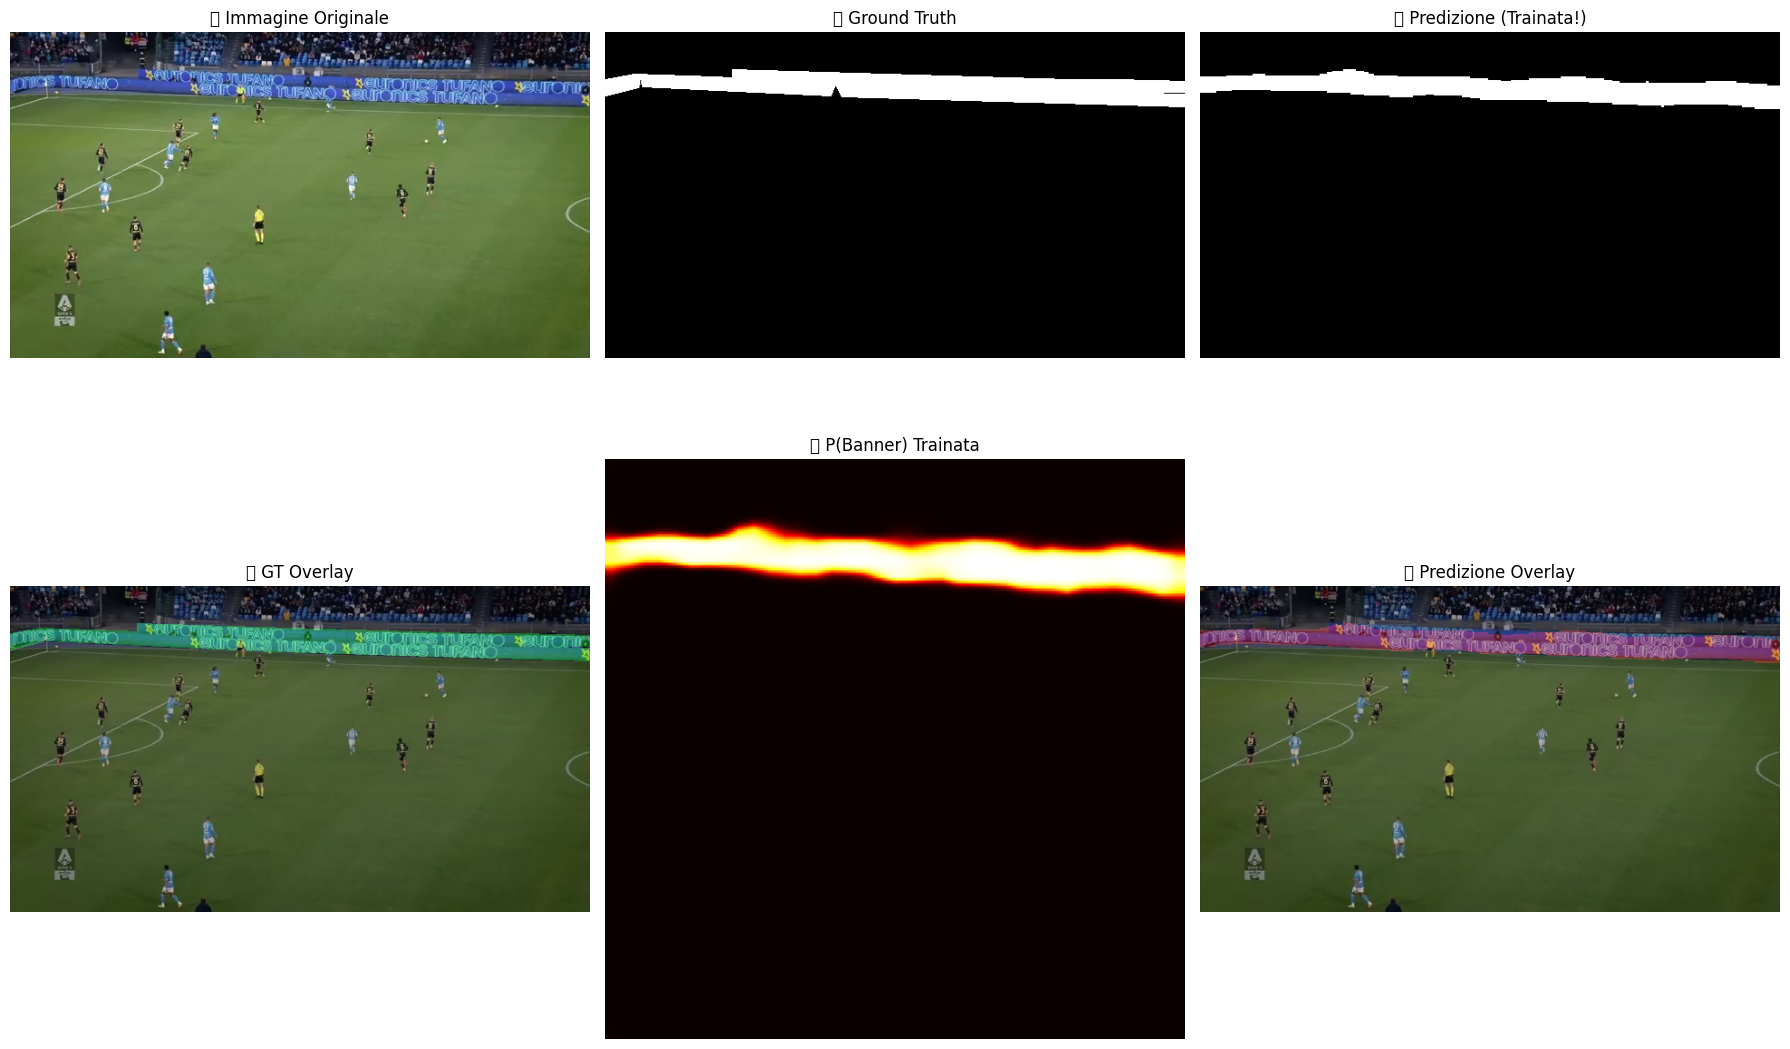

📊 Metriche per sample 0:
   🎯 IoU Banner: 0.854
   📊 Accuracy: 0.990

🧪 Sample 2:


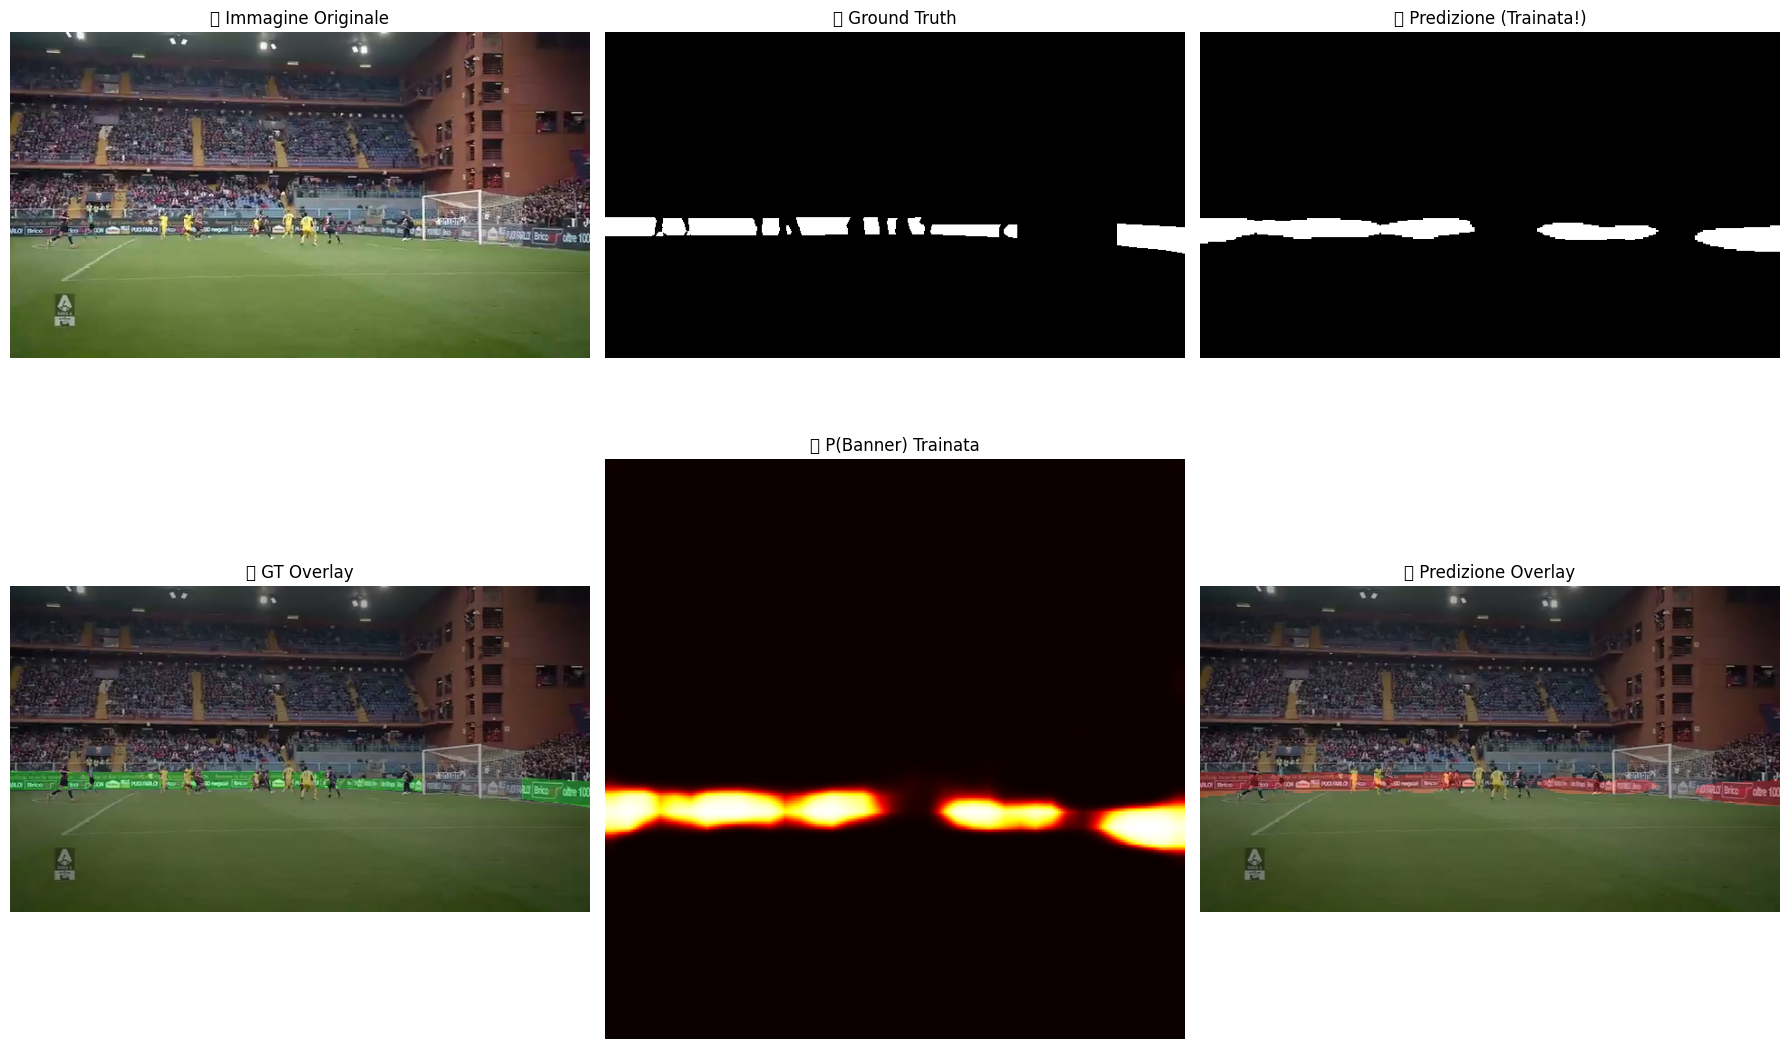

📊 Metriche per sample 1:
   🎯 IoU Banner: 0.652
   📊 Accuracy: 0.984

🧪 Sample 3:


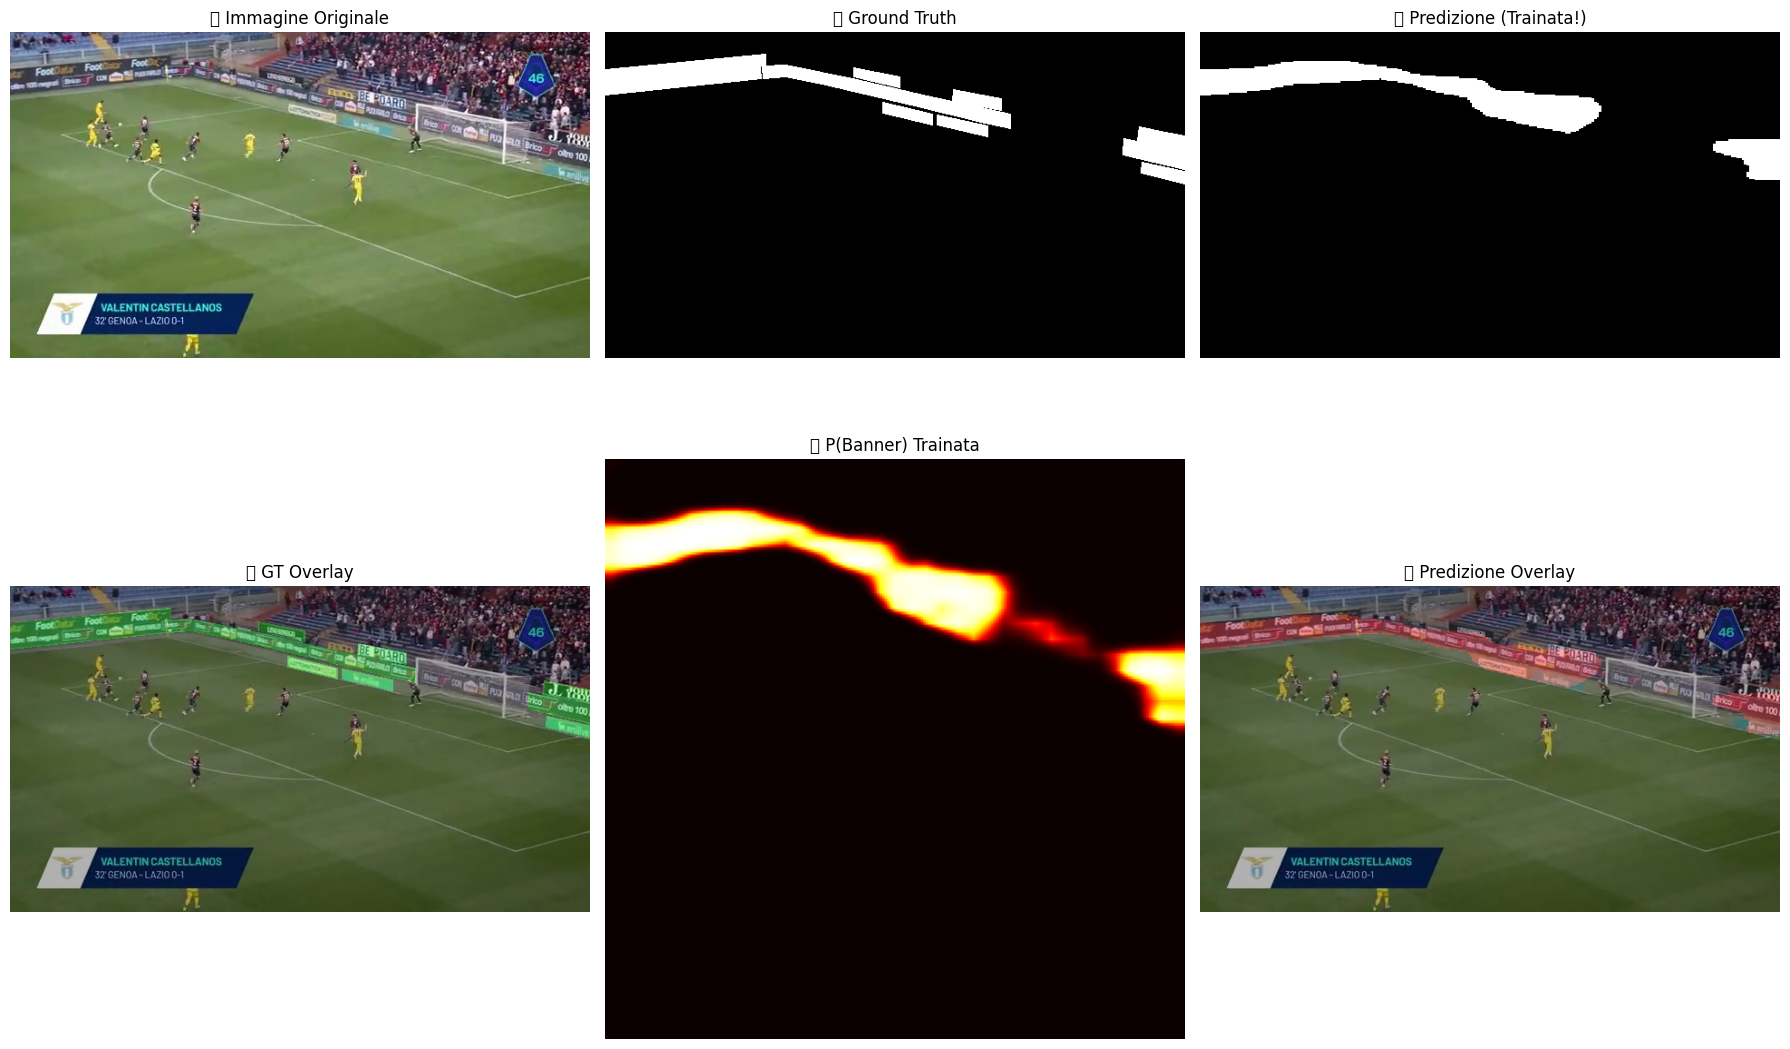

📊 Metriche per sample 2:
   🎯 IoU Banner: 0.780
   📊 Accuracy: 0.985

🎉 TEST COMPLETATO!
🚀 Il modello DINOv2 è stato trainato sui tuoi banner di calcio!


In [19]:
# 🧪 TEST PREDIZIONI SUL MODELLO TRAINATO
print('🧪 TESTIAMO IL MODELLO TRAINATO!')

segmentation_model.eval()

def test_trained_model(sample_idx=0):
    """Testa il modello trainato su un sample"""
    
    # Prendi sample dal validation set
    val_sample = val_data[sample_idx]
    
    # Carica immagine originale
    original_image = Image.open(val_sample['image_path']).convert('RGB')
    ground_truth_mask = val_sample['mask']
    
    # Preprocessa per il modello
    input_tensor = transform(original_image.resize((224, 224))).unsqueeze(0).to(device)
    
    # Predizione
    with torch.no_grad():
        logits = segmentation_model(input_tensor)
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1)
    
    # Converti a numpy
    pred_mask = prediction[0].cpu().numpy()
    banner_prob = probs[0, 1].cpu().numpy()
    
    # Resize predizione a dimensione originale (640x360)
    pred_mask_resized = cv2.resize(pred_mask, (640, 360), interpolation=cv2.INTER_NEAREST)
    
    # Visualizza risultati
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Prima riga: originale, GT, predizione
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('🖼️ Immagine Originale')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(ground_truth_mask, cmap='gray')
    axes[0, 1].set_title('🎭 Ground Truth')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred_mask_resized, cmap='gray')
    axes[0, 2].set_title('🤖 Predizione (Trainata!)')
    axes[0, 2].axis('off')
    
    # Seconda riga: overlay GT, probabilità, overlay predizione
    overlay_gt = np.array(original_image)
    mask_colored_gt = np.zeros_like(overlay_gt)
    mask_colored_gt[ground_truth_mask == 1] = [0, 255, 0]  # Verde per GT
    blended_gt = cv2.addWeighted(overlay_gt, 0.7, mask_colored_gt, 0.3, 0)
    
    axes[1, 0].imshow(blended_gt)
    axes[1, 0].set_title('🎨 GT Overlay')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(banner_prob, cmap='hot')
    axes[1, 1].set_title('🔥 P(Banner) Trainata')
    axes[1, 1].axis('off')
    
    overlay_pred = np.array(original_image)
    mask_colored_pred = np.zeros_like(overlay_pred)
    mask_colored_pred[pred_mask_resized == 1] = [255, 0, 0]  # Rosso per predizione
    blended_pred = cv2.addWeighted(overlay_pred, 0.7, mask_colored_pred, 0.3, 0)
    
    axes[1, 2].imshow(blended_pred)
    axes[1, 2].set_title('🎯 Predizione Overlay')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calcola metriche per questo sample
    gt_resized = cv2.resize(ground_truth_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
    
    # IoU
    intersection = np.logical_and(pred_mask == 1, gt_resized == 1).sum()
    union = np.logical_or(pred_mask == 1, gt_resized == 1).sum()
    iou = intersection / union if union > 0 else 0
    
    # Accuracy
    accuracy = np.mean(pred_mask == gt_resized)
    
    print(f'📊 Metriche per sample {sample_idx}:')
    print(f'   🎯 IoU Banner: {iou:.3f}')
    print(f'   📊 Accuracy: {accuracy:.3f}')
    
    return iou, accuracy

# Testa su primi 3 validation samples
print('🔍 TEST SU VALIDATION SAMPLES:')
for i in range(min(3, len(val_data))):
    print(f'\n🧪 Sample {i+1}:')
    test_trained_model(i)

print('\n🎉 TEST COMPLETATO!')
print('🚀 Il modello DINOv2 è stato trainato sui tuoi banner di calcio!')

In [20]:
# Aggiungi questa cella per testare su più esempi
def analyze_model_performance():
    """Analizza prestazioni su tutto il validation set"""
    
    banner_ious = []
    accuracies = []
    
    segmentation_model.eval()
    
    for i, sample in enumerate(val_data):
        # Test come fatto prima
        original_image = Image.open(sample['image_path']).convert('RGB')
        ground_truth_mask = sample['mask']
        
        input_tensor = transform(original_image.resize((224, 224))).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = segmentation_model(input_tensor)
            prediction = torch.argmax(logits, dim=1)
        
        pred_mask = prediction[0].cpu().numpy()
        gt_resized = cv2.resize(ground_truth_mask, (224, 224), interpolation=cv2.INTER_NEAREST)
        
        # Calcola metriche
        intersection = np.logical_and(pred_mask == 1, gt_resized == 1).sum()
        union = np.logical_or(pred_mask == 1, gt_resized == 1).sum()
        iou = intersection / union if union > 0 else 0
        accuracy = np.mean(pred_mask == gt_resized)
        
        banner_ious.append(iou)
        accuracies.append(accuracy)
        
        print(f'Sample {i+1}: IoU={iou:.3f}, Acc={accuracy:.3f}')
    
    print(f'\n📊 PERFORMANCE SUMMARY:')
    print(f'   Mean IoU: {np.mean(banner_ious):.3f} ± {np.std(banner_ious):.3f}')
    print(f'   Mean Acc: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}')
    print(f'   Min IoU: {np.min(banner_ious):.3f}')
    print(f'   Max IoU: {np.max(banner_ious):.3f}')

analyze_model_performance()

Sample 1: IoU=0.854, Acc=0.990
Sample 2: IoU=0.652, Acc=0.984
Sample 3: IoU=0.780, Acc=0.985
Sample 4: IoU=0.867, Acc=0.989

📊 PERFORMANCE SUMMARY:
   Mean IoU: 0.788 ± 0.085
   Mean Acc: 0.987 ± 0.003
   Min IoU: 0.652
   Max IoU: 0.867


In [21]:
# Salva il modello trainato
torch.save({
    'model_state_dict': segmentation_model.state_dict(),
    'best_val_iou': best_val_iou,
    'training_history': {
        'train_losses': train_losses,
        'train_ious': train_ious,
        'val_losses': val_losses, 
        'val_ious': val_ious
    }
}, 'dinov2_banner_segmentation.pth')

print('💾 Modello salvato in: dinov2_banner_segmentation.pth')

💾 Modello salvato in: dinov2_banner_segmentation.pth
